In [1]:
import bioframe as bf
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/mpra/merged"

In [3]:
models = [
    #"CADD.RawScore",
    "phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_models = [
    "Enformer",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    #"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = load_dataset(f"../../{dataset_path}", split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873
...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915


In [4]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates,Enformer_feature_0,...,HyenaDNA_embedding_246,HyenaDNA_embedding_247,HyenaDNA_embedding_248,HyenaDNA_embedding_249,HyenaDNA_embedding_250,HyenaDNA_embedding_251,HyenaDNA_embedding_252,HyenaDNA_embedding_253,HyenaDNA_embedding_254,HyenaDNA_embedding_255
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605,-0.139118,...,471079.12500,713319.3750,291782.31250,269786.43750,369671.87500,360241.31250,763255.8125,504375.62500,226631.718750,235293.468750
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605,-4.508843,...,471080.50000,713317.1250,291781.75000,269785.65625,369672.90625,360243.71875,763257.2500,504379.21875,226631.703125,235292.171875
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605,-2.765857,...,471082.31250,713318.4375,291783.40625,269784.65625,369675.59375,360241.75000,763254.9375,504380.81250,226631.265625,235293.093750
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873,-3.232728,...,471094.53125,713301.7500,291772.18750,269791.68750,369659.25000,360266.87500,763239.3750,504392.84375,226641.656250,235292.828125
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873,-0.280594,...,471094.09375,713302.3750,291774.93750,269790.68750,369657.90625,360263.59375,763239.7500,504388.03125,226643.218750,235291.578125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926,-1.196416,...,526592.62500,847666.7500,269663.87500,251571.40625,406427.87500,290298.34375,765279.3125,491124.06250,234315.843750,262013.109375
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926,-0.555294,...,526597.18750,847689.9375,269664.09375,251570.06250,406428.75000,290296.90625,765280.1250,491121.81250,234317.187500,262016.265625
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926,-2.405801,...,526593.25000,847675.0625,269664.25000,251572.25000,406426.62500,290297.34375,765278.5000,491121.59375,234318.218750,262013.953125
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915,-7.760788,...,526598.81250,847719.3750,269662.06250,251562.43750,406447.71875,290309.00000,765294.7500,491159.56250,234292.265625,262037.000000


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

In [6]:
V["Enformer_l2"] = -np.linalg.norm(V[features["Enformer"]], axis=1)
models.append("Enformer_l2")

In [7]:
# optional
#V = V[V.p_value < 1e-5].copy()
#V.shape

In [6]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates,Enformer_feature_0,...,HyenaDNA_embedding_246,HyenaDNA_embedding_247,HyenaDNA_embedding_248,HyenaDNA_embedding_249,HyenaDNA_embedding_250,HyenaDNA_embedding_251,HyenaDNA_embedding_252,HyenaDNA_embedding_253,HyenaDNA_embedding_254,HyenaDNA_embedding_255
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605,-0.139118,...,471079.12500,713319.3750,291782.31250,269786.43750,369671.87500,360241.31250,763255.8125,504375.62500,226631.718750,235293.468750
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605,-4.508843,...,471080.50000,713317.1250,291781.75000,269785.65625,369672.90625,360243.71875,763257.2500,504379.21875,226631.703125,235292.171875
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605,-2.765857,...,471082.31250,713318.4375,291783.40625,269784.65625,369675.59375,360241.75000,763254.9375,504380.81250,226631.265625,235293.093750
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873,-3.232728,...,471094.53125,713301.7500,291772.18750,269791.68750,369659.25000,360266.87500,763239.3750,504392.84375,226641.656250,235292.828125
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873,-0.280594,...,471094.09375,713302.3750,291774.93750,269790.68750,369657.90625,360263.59375,763239.7500,504388.03125,226643.218750,235291.578125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926,-1.196416,...,526592.62500,847666.7500,269663.87500,251571.40625,406427.87500,290298.34375,765279.3125,491124.06250,234315.843750,262013.109375
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926,-0.555294,...,526597.18750,847689.9375,269664.09375,251570.06250,406428.75000,290296.90625,765280.1250,491121.81250,234317.187500,262016.265625
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926,-2.405801,...,526593.25000,847675.0625,269664.25000,251572.25000,406426.62500,290297.34375,765278.5000,491121.59375,234318.218750,262013.953125
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915,-7.760788,...,526598.81250,847719.3750,269662.06250,251562.43750,406447.71875,290309.00000,765294.7500,491159.56250,234292.265625,262037.000000


In [7]:
V["label"] = V.effect_size.abs()

In [16]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, spearmanr(V_train.label, -V_train[f])[0]]
        for f in features
    ], columns=["Model", "Spearman"]).sort_values("Spearman", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', RidgeCV(
            alphas=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6],
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    #print(clf.named_steps["linear"].alpha_)
    return -clf.predict(V_test[features])

supervised_models = [
    #("Best inner product", train_predict_best_inner_product),
    #("LR(inner products)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features)),
    #("LR(inner products + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["Enformer_l2"])),
    #("LR(inner products + LLR)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA"])),
    #("LR(inner products + LLR + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA", "Enformer_l2"])),
]


for m in embedding_models:
    #supervised_models.append((
    #    f"{m} - best inner product",
    #    lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    #))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))


supervised_models.append((
    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
))    
    

def train_predict_lr_split(V, model_name, model):
    all_pos = np.unique(V.pos)  # sorted
    # we want the first 10 positions for the first split, then 10-20
    # for the second split, then again 30-40 for first, etc.
    s = 10
    splits = [
        np.concatenate([all_pos[i:i+s] for i in range(0, len(all_pos), 2*s)]),
        np.concatenate([all_pos[i:i+s] for i in range(s, len(all_pos), 2*s)]),
    ]
    assert set(splits[0]).isdisjoint(set(splits[1]))

    for split in splits:
        mask_train = V.pos.isin(split)
        mask_test = ~mask_train
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])
    return V[model_name].values
        

for element in tqdm(V.element.unique()):
    V_e = V[V.element==element]
    for m, model in supervised_models:
        V.loc[V.element==element, m] = train_predict_lr_split(V_e, m, model)
        if m not in models: models.append(m)
V

100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates,Enformer_feature_0,...,HyenaDNA_embedding_252,HyenaDNA_embedding_253,HyenaDNA_embedding_254,HyenaDNA_embedding_255,label,Enformer - LR(inner products),GPN-MSA - LR(inner products),NT - LR(inner products),HyenaDNA - LR(inner products),GPN-MSA + Enformer - LR(inner products+abs(delta features))
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605,-0.139118,...,763255.8125,504375.62500,226631.718750,235293.468750,0.061260,-0.069672,-0.348049,-0.063926,-0.352767,-0.131000
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605,-4.508843,...,763257.2500,504379.21875,226631.703125,235292.171875,0.044592,-0.008010,-0.351831,-0.061845,-0.338307,-0.096296
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605,-2.765857,...,763254.9375,504380.81250,226631.265625,235293.093750,0.008868,-0.074784,-0.395831,-0.068703,-0.293251,-0.145500
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873,-3.232728,...,763239.3750,504392.84375,226641.656250,235292.828125,0.121466,-0.029046,-0.330341,0.304454,-0.492865,-0.116664
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873,-0.280594,...,763239.7500,504388.03125,226643.218750,235291.578125,0.064338,0.010646,-0.213622,0.291347,-0.400782,-0.063855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926,-1.196416,...,765279.3125,491124.06250,234315.843750,262013.109375,0.173105,-0.161497,-0.148073,-0.081634,-0.083449,-0.156101
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926,-0.555294,...,765280.1250,491121.81250,234317.187500,262016.265625,0.009252,-0.127342,-0.184370,-0.116103,-0.084808,-0.124776
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926,-2.405801,...,765278.5000,491121.59375,234318.218750,262013.953125,0.094613,-0.160956,-0.195862,-0.094808,-0.080915,-0.158033
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915,-7.760788,...,765294.7500,491159.56250,234292.265625,262037.000000,0.175202,-0.256400,-0.167804,-0.094785,-0.101756,-0.274674


## Testing

In [17]:
rows = []
for element in tqdm(V.element.unique()):
    V_e = V[V.element==element]
    y = V_e.label
    for m in models:
        x = -V_e[m]
        rows.append([
            element,
            m,
            pearsonr(x, y)[0],
            spearmanr(x, y)[0],
        ])
results = pd.DataFrame(rows, columns=["Element", "Model", "Pearson", "Spearman"])
results

100%|██████████| 16/16 [00:00<00:00, 21.34it/s]


,Element,Model,Pearson,Spearman
0,SORT1,phyloP-100-vertebrates,-0.135189,-0.096452
1,SORT1,Enformer - LR(inner products),0.675275,0.583653
2,SORT1,GPN-MSA - LR(inner products),0.415781,0.370572
3,SORT1,NT - LR(inner products),0.274869,0.291793
4,SORT1,HyenaDNA - LR(inner products),0.339726,0.299811
...,...,...,...,...
91,F9,Enformer - LR(inner products),0.614402,0.370800
92,F9,GPN-MSA - LR(inner products),0.389711,0.194398
93,F9,NT - LR(inner products),0.242626,0.183947
94,F9,HyenaDNA - LR(inner products),0.363966,0.214691


In [18]:
results.groupby("Model").Pearson.mean().sort_values(ascending=False)

Model
GPN-MSA + Enformer - LR(inner products+abs(delta features))    0.599399
Enformer - LR(inner products)                                  0.580774
GPN-MSA - LR(inner products)                                   0.341661
HyenaDNA - LR(inner products)                                  0.293072
NT - LR(inner products)                                        0.238967
phyloP-100-vertebrates                                         0.164211
Name: Pearson, dtype: float64

In [19]:
results.groupby("Model").Spearman.mean().sort_values(ascending=False)

Model
GPN-MSA + Enformer - LR(inner products+abs(delta features))    0.415362
Enformer - LR(inner products)                                  0.378980
GPN-MSA - LR(inner products)                                   0.277789
HyenaDNA - LR(inner products)                                  0.238370
NT - LR(inner products)                                        0.226597
phyloP-100-vertebrates                                         0.131841
Name: Spearman, dtype: float64

In [20]:
agg_results = results.groupby("Model")[["Pearson", "Spearman"]].mean().reset_index()
agg_results

,Model,Pearson,Spearman
0,Enformer - LR(inner products),0.580774,0.378980
1,GPN-MSA + Enformer - LR(inner products+abs(del...,0.599399,0.415362
2,GPN-MSA - LR(inner products),0.341661,0.277789
3,HyenaDNA - LR(inner products),0.293072,0.238370
4,NT - LR(inner products),0.238967,0.226597
5,phyloP-100-vertebrates,0.164211,0.131841


<Axes: xlabel='Pearson', ylabel='Model'>

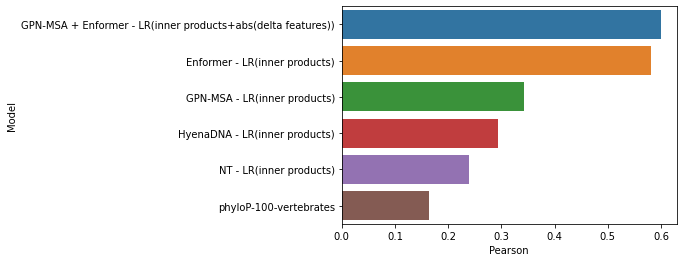

In [21]:
sns.barplot(data=agg_results.sort_values("Pearson", ascending=False), y="Model", x="Pearson")

<Axes: xlabel='Spearman', ylabel='Model'>

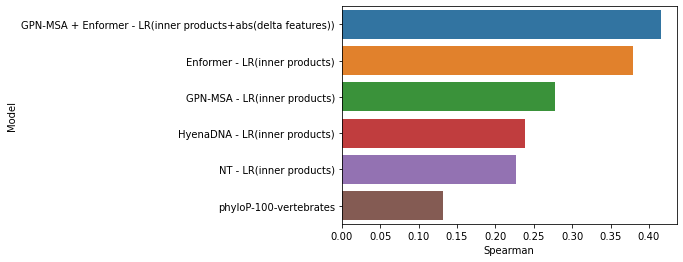

In [22]:
sns.barplot(data=agg_results.sort_values("Spearman", ascending=False), y="Model", x="Spearman")

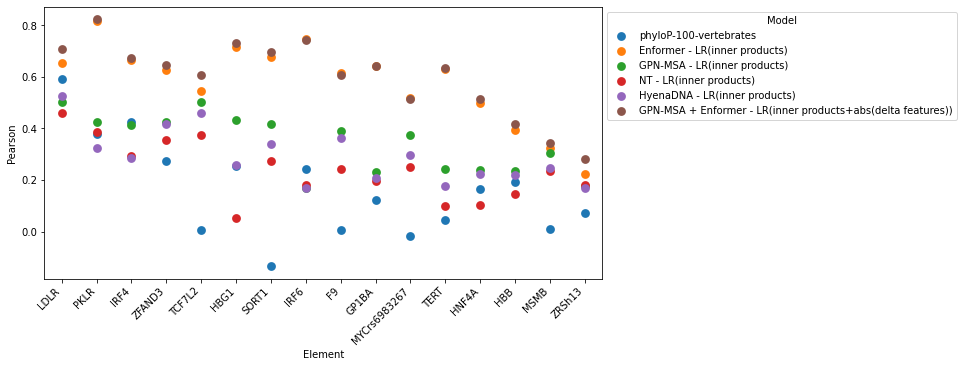

In [23]:
#metric = "Spearman"
metric = "Pearson"

plt.figure(figsize=(10, 5))
g = sns.pointplot(
    data=results,
    #data=results.replace({"GPN-MSA": "GPN-MSA (LLR)"}),
    #data=results[~results.Model.str.contains("best") & ~results.Model.str.contains("full")],
    #data=results[results.Model.str.contains("GPN-MSA")],
    hue="Model",
    x="Element",
    y=metric,
    join=False,
    order=results.groupby("Element")[metric].mean().sort_values(ascending=False).index.values,
);
plt.xticks(rotation=45, ha="right");
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));

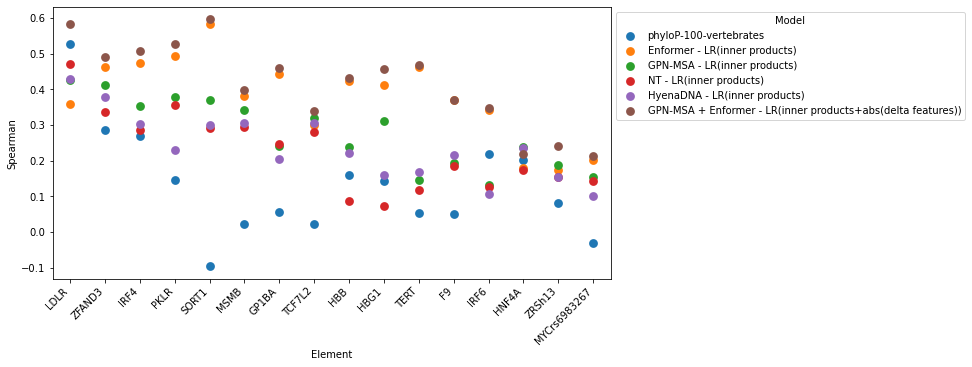

In [24]:
metric = "Spearman"
#metric = "Pearson"

plt.figure(figsize=(10, 5))
g = sns.pointplot(
    data=results,
    #data=results.replace({"GPN-MSA": "GPN-MSA (LLR)"}),
    #data=results[~results.Model.str.contains("best") & ~results.Model.str.contains("full")],
    #data=results[results.Model.str.contains("GPN-MSA")],
    hue="Model",
    x="Element",
    y=metric,
    join=False,
    order=results.groupby("Element")[metric].mean().sort_values(ascending=False).index.values,
);
plt.xticks(rotation=45, ha="right");
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));